In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from random import shuffle

# Get the data

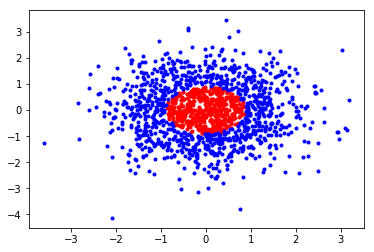

In [2]:
# number of features in
nf   = 2
# number of classes
nClass = 2

X = torch.randn(2,1500)
R = torch.sqrt(X[0,:]**2 + X[1,:]**2)
indRed   = (R < 0.9).nonzero()
indBlue  = (R >= 0.9).nonzero()


C = torch.zeros(1500,dtype = torch.int64)
C[indRed]  = 0
C[indBlue] = 1

plt.plot(X.numpy()[0,indRed],X.numpy()[1,indRed],'.r')
plt.plot(X.numpy()[0,indBlue],X.numpy()[1,indBlue],'.b')


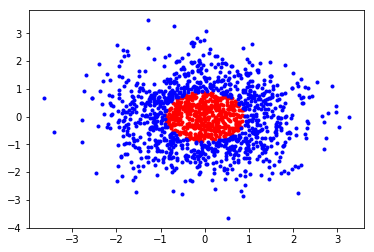

In [3]:
# Get a validation set
XVal = torch.randn(2,1500)
R = torch.sqrt(XVal[0,:]**2 + XVal[1,:]**2)
indRed   = (R < 0.9).nonzero()
indBlue  = (R >= 0.9).nonzero()


CVal = torch.zeros(1500,dtype = torch.int64)
CVal[indRed]  = 0
CVal[indBlue] = 1

plt.plot(XVal.numpy()[0,indRed],XVal.numpy()[1,indRed],'.r')
plt.plot(XVal.numpy()[0,indBlue],XVal.numpy()[1,indBlue],'.b')

# Design the simple ResNet

In [4]:
lossFunc = nn.CrossEntropyLoss()

def misfit(X,W,bias,C):
    n = W.shape
    X = X.view(n[1],-1)
    S = torch.matmul(W,X) 
    S += bias.unsqueeze(1)
    return lossFunc(S.t(),C)

In [5]:
class ResNet(nn.Module):

    def __init__(self,NetGeo):
        super().__init__()
        
        self.NetGeo = NetGeo
        
    def forward(self,x,K,b):
        dt = self.NetGeo[1]
        nt = self.NetGeo[0]
        
        # Allocate space for all times
        X  = torch.zeros(x.shape[0],x.shape[1],nt+1)
        X[:,:,0] = x
        
        # forward Euler (to be improved later)
        for i in range(nt):
            z = torch.matmul(K[i],x)
            x = x + dt*F.relu(z+b[i])
            ind = i+1
            X[:,:,ind] = x
            
            
        return x,X 


# Initialize all parameter

In [24]:
dt = 0.1
nt = 64
NG    = [nt,dt]
net   = ResNet(NG)

# initialize K's
K = []
for i in range(nt):
    Ki  = nn.Parameter(torch.randn(nf, nf)*1e-3)
    K.append(Ki)
    
b  = nn.Parameter(torch.randn(nt)*1e-3)
        

In [25]:
# Run the network
xF,Xpath = net(X,K,b)

In [26]:

# weights for linear classifier    
W      = nn.Parameter(torch.randn(nClass,nf)*1e-3,requires_grad=True)
bW     = nn.Parameter(torch.randn(nClass)*1e-2,requires_grad=True)

nparout = np.prod(W.shape) + np.prod(bW.shape) + np.prod(K[0].shape)*nt + nt

print('Total number of parameter',nparout)
print('Total number of data',C.shape[0])

Total number of parameter 326
Total number of data 1500


In [27]:
# run the network
x,_ = net(X,K,b)
label = C
loss = misfit(x,W,bW,label)
print('Initial loss = ', loss.detach().numpy())    
print('Sanity Check = ',np.log(2.0))

Initial loss =  0.69264305
Sanity Check =  0.6931471805599453


In [28]:
batchSize = 16

In [29]:
import torch.optim as optim
optimizer = optim.SGD([{'params': W},{'params': K},{'params': bW},{'params': b}], lr = 1e0,momentum=0.0)

In [30]:
for epoch in range(30):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    while ind<X.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X[:,ind:ind+batchSize]
        labels = C[ind:ind+batchSize]

        # forward 
        x,_   = net(inputs,K,b)
        lossi = misfit(x,W,bW,labels)
        if i==0:
            loss = lossi
        else:
            loss  += lossi
            
        lossi.backward()
        optimizer.step()
        g += torch.norm(W.grad) + torch.norm(bW.grad)    
        ind += batchSize
        
    print('%d  %.3f   %.3f'% (epoch+1, loss, g))

print('Finished Training')

1  62.461   29.965
2  61.403   26.490
3  57.699   23.593
4  43.456   24.104
5  29.429   19.314
6  24.139   16.077
7  21.583   14.735
8  20.395   13.746
9  18.631   13.308
10  18.122   13.224
11  17.770   13.571
12  16.064   12.911
13  16.296   11.862
14  15.369   12.103
15  14.481   11.047
16  13.257   10.829
17  13.817   11.114
18  12.352   10.550
19  12.543   10.720
20  14.615   12.121
21  12.440   10.508
22  13.261   11.395
23  13.150   11.597
24  12.968   11.064
25  10.920   9.863
26  11.505   10.403
27  11.020   10.115
28  9.385   8.908
29  10.633   9.368
30  10.809   10.088
Finished Training


# Plot the results on validation

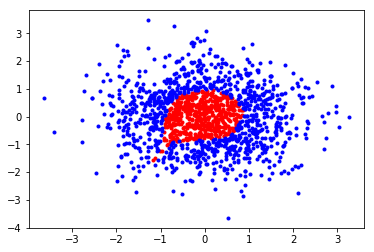

In [31]:
x,_      = net(XVal,K,b)
S      = torch.matmul(W,x)
S     += bW.unsqueeze(1)
_,Cpred = torch.max(S,dim=0)


indRed   = (Cpred==0).nonzero()
indBlue  = (Cpred==1).nonzero()


plt.plot(XVal[0,indRed].numpy(),XVal[1,indRed].numpy(),'.r')
plt.plot(XVal[0,indBlue].numpy(),XVal[1,indBlue].numpy(),'.b')


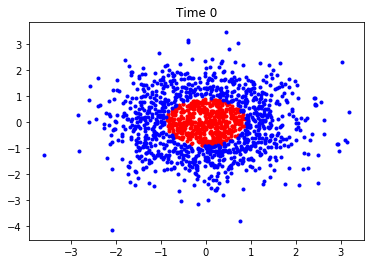

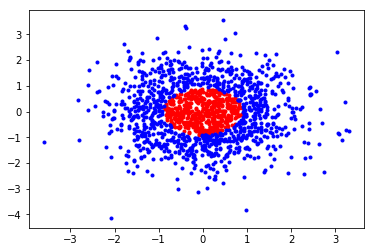

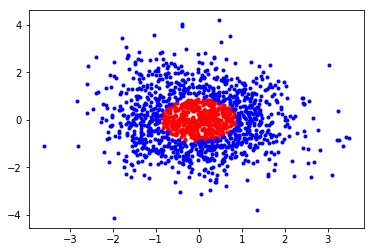

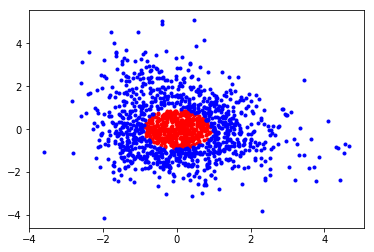

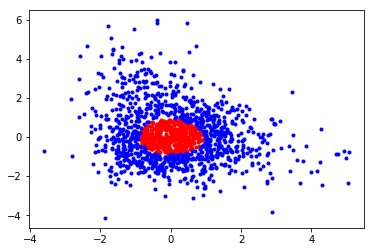

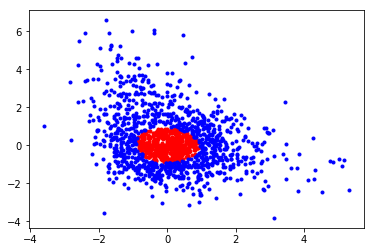

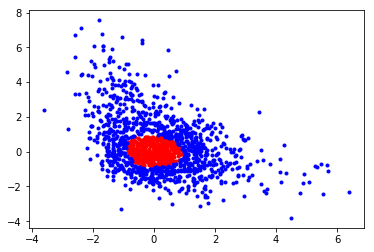

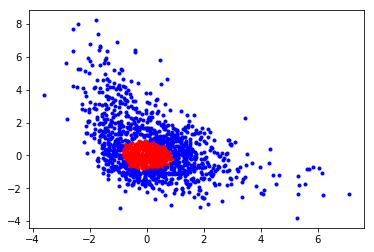

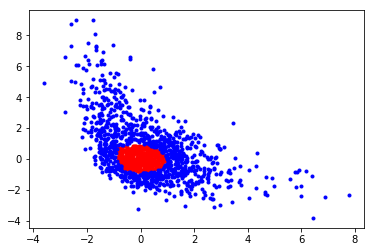

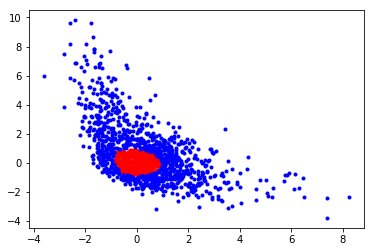

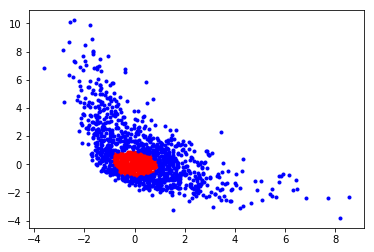

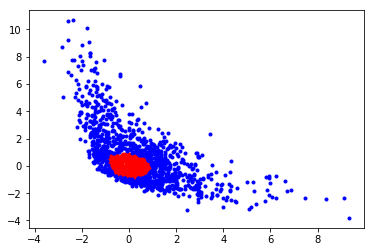

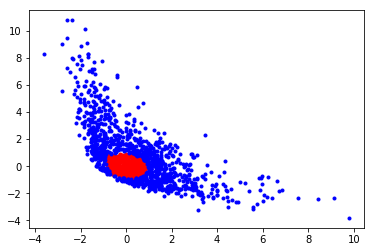

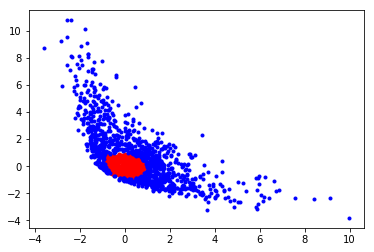

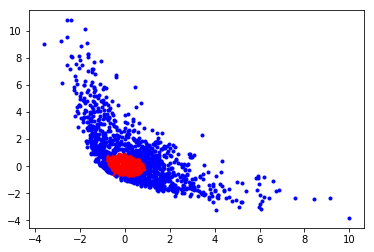

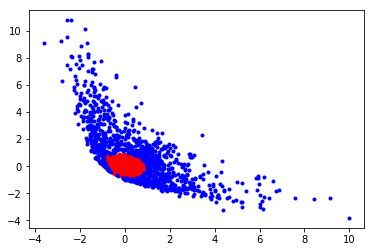

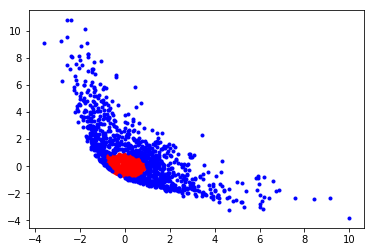

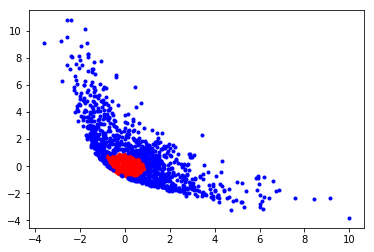

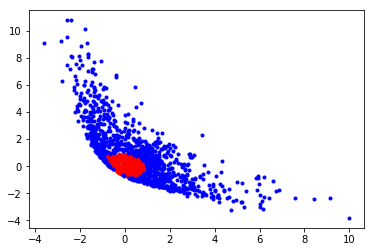

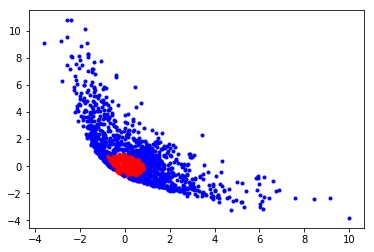

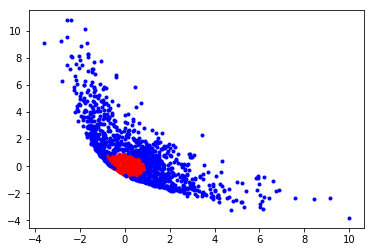

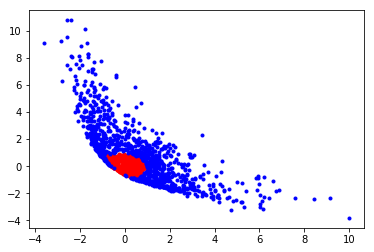

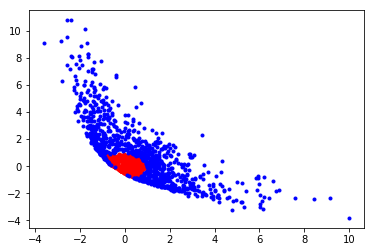

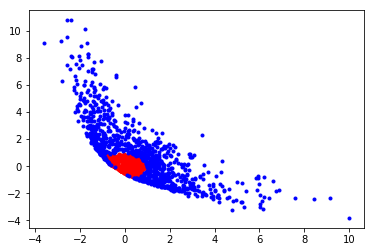

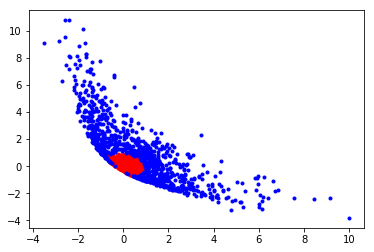

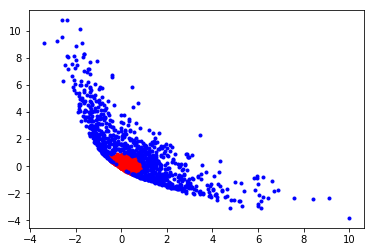

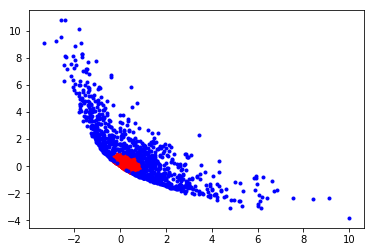

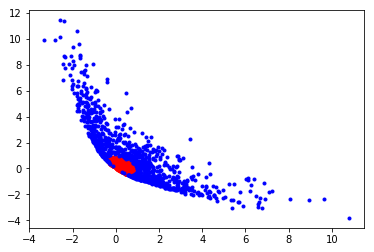

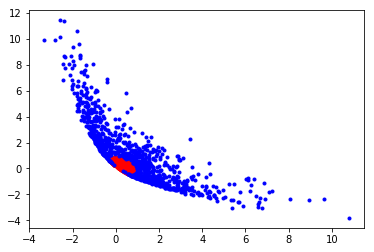

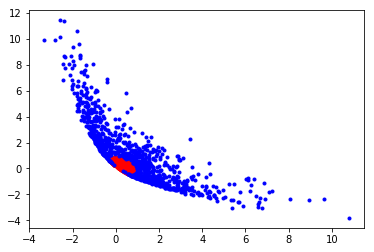

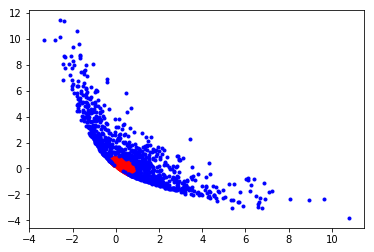

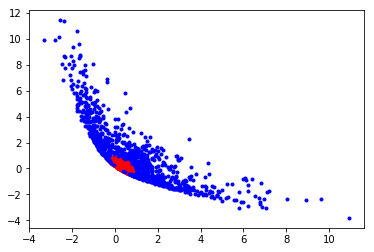

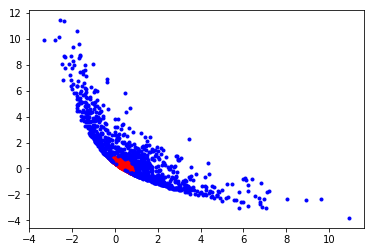

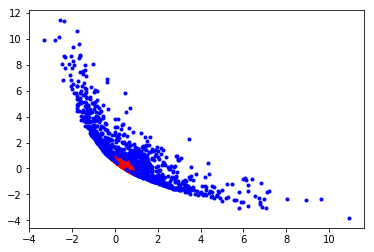

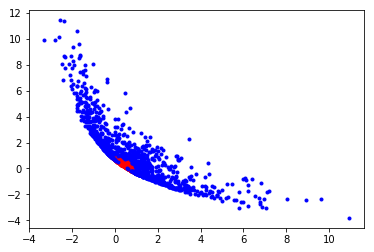

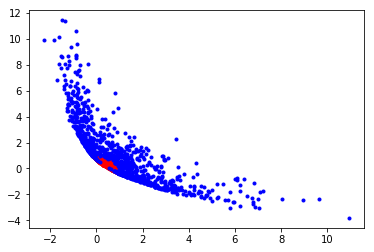

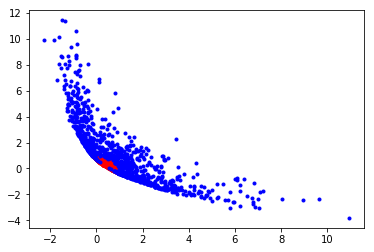

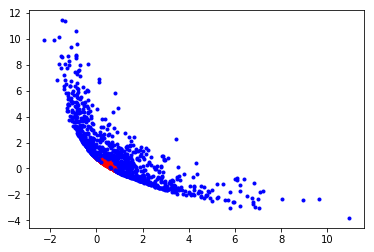

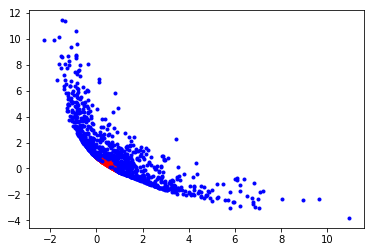

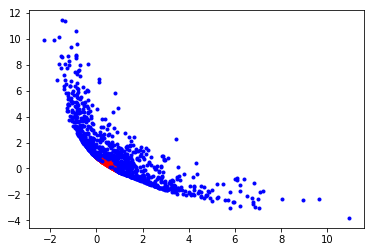

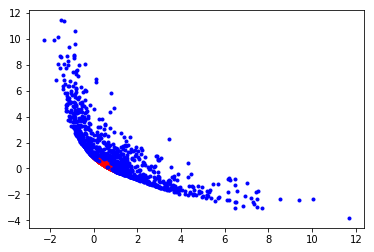

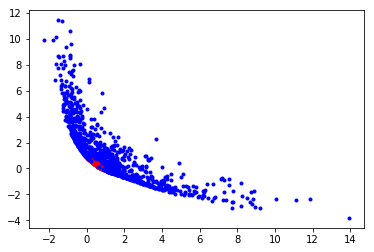

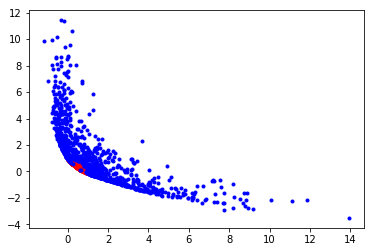

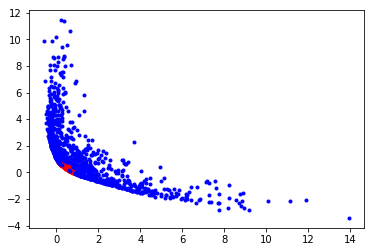

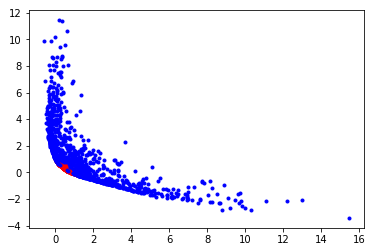

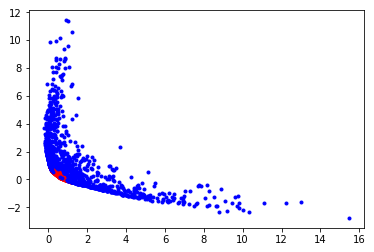

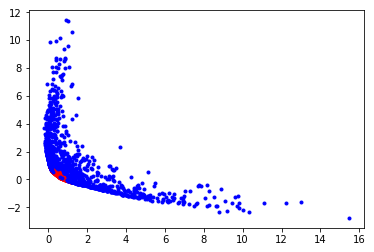

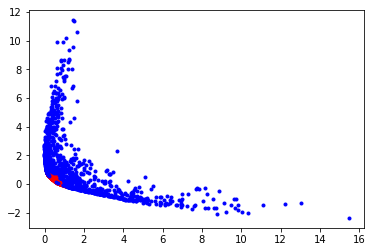

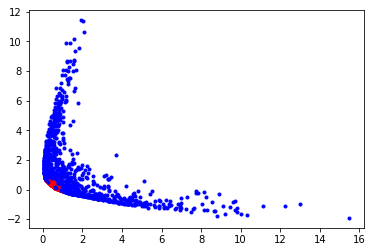

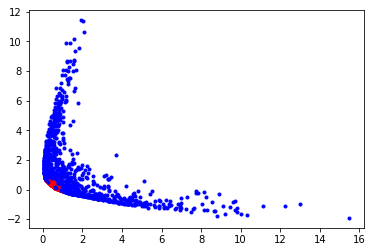

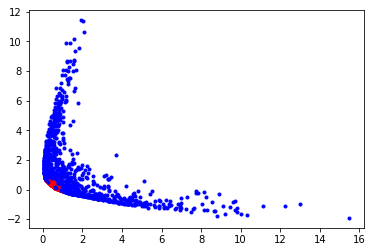

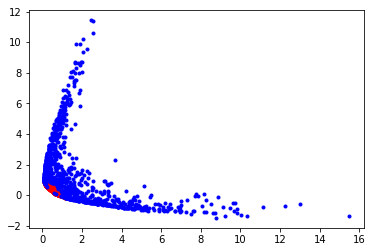

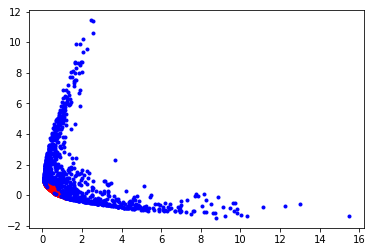

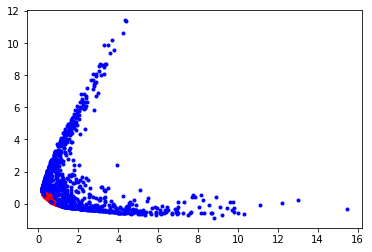

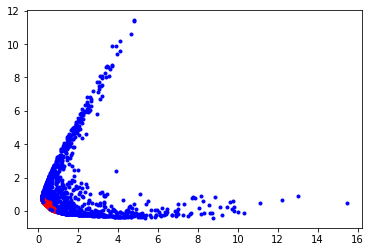

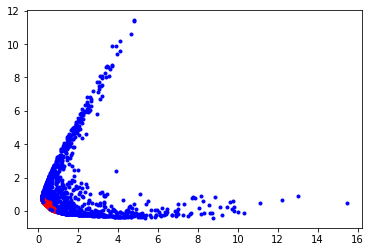

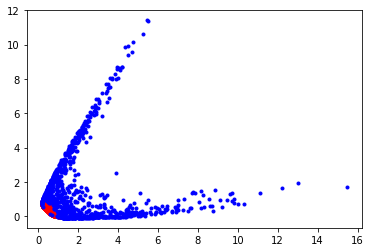

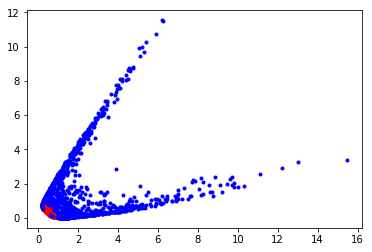

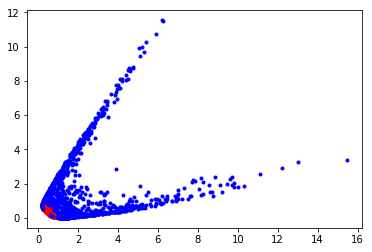

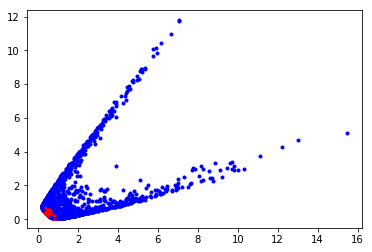

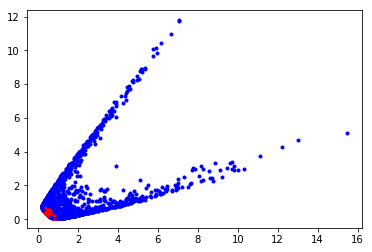

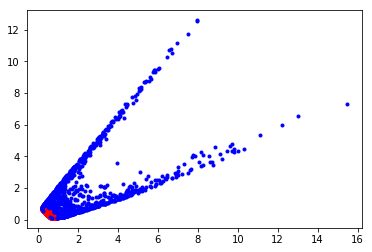

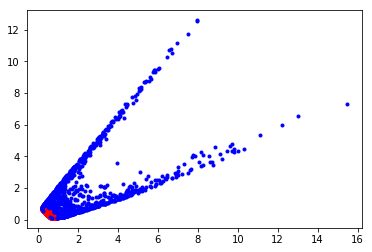

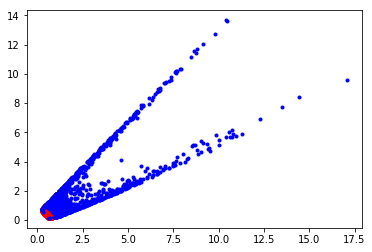

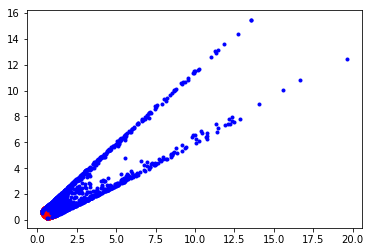

In [32]:
# plot the path
x,Xpath      = net(X,K,b)

indRed   = (C==0).nonzero()
indBlue  = (C==1).nonzero()

fig, ax = plt.subplots()

for i in range(65):
    Xi = Xpath[:,:,i].detach().numpy()
    
    ax.cla()
    plt.plot(Xi[0,indRed],Xi[1,indRed],'.r')
    plt.plot(Xi[0,indBlue],Xi[1,indBlue],'.b')

    ax.set_title("Time {}".format(i))
    plt.pause(0.1)